## Predicting Heart Disease Through Clinical Results {-}
#### Data Preparation, Modeling, Evaluation, and Interpretation {-}

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

# Set up some basic configurations for consistency
pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", palette="deep")


In [2]:
df = pd.read_csv("HeartDiseaseTrain-Test.csv")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (1025, 14)


,age,sex,chest_pain_type,resting_blood_pressure,cholestoral,fasting_blood_sugar,rest_ecg,Max_heart_rate,exercise_induced_angina,oldpeak,slope,vessels_colored_by_flourosopy,thalassemia,target
0,52,Male,Typical angina,125,212,Lower than 120 mg/ml,ST-T wave abnormality,168,No,1.0,Downsloping,Two,Reversable Defect,0
1,53,Male,Typical angina,140,203,Greater than 120 mg/ml,Normal,155,Yes,3.1,Upsloping,Zero,Reversable Defect,0
2,70,Male,Typical angina,145,174,Lower than 120 mg/ml,ST-T wave abnormality,125,Yes,2.6,Upsloping,Zero,Reversable Defect,0
3,61,Male,Typical angina,148,203,Lower than 120 mg/ml,ST-T wave abnormality,161,No,0.0,Downsloping,One,Reversable Defect,0
4,62,Female,Typical angina,138,294,Greater than 120 mg/ml,ST-T wave abnormality,106,No,1.9,Flat,Three,Fixed Defect,0


In [3]:
categorical_cols = df.select_dtypes(include=["object"]).columns.tolist()
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

print("\nCategorical Columns:", categorical_cols)
print("Numeric Columns:", numeric_cols)



Categorical Columns: ['sex', 'chest_pain_type', 'fasting_blood_sugar', 'rest_ecg', 'exercise_induced_angina', 'slope', 'vessels_colored_by_flourosopy', 'thalassemia']
Numeric Columns: ['age', 'resting_blood_pressure', 'cholestoral', 'Max_heart_rate', 'oldpeak', 'target']


In [4]:
print("\nMissing values per column:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)


Missing values per column:
 age                              0
sex                              0
chest_pain_type                  0
resting_blood_pressure           0
cholestoral                      0
fasting_blood_sugar              0
rest_ecg                         0
Max_heart_rate                   0
exercise_induced_angina          0
oldpeak                          0
slope                            0
vessels_colored_by_flourosopy    0
thalassemia                      0
target                           0
dtype: int64

Data types:
 age                                int64
sex                               object
chest_pain_type                   object
resting_blood_pressure             int64
cholestoral                        int64
fasting_blood_sugar               object
rest_ecg                          object
Max_heart_rate                     int64
exercise_induced_angina           object
oldpeak                          float64
slope                             object
ves

Initial analysis of the data shows the following characteristics:

- There are no columns with missing data, so this data set looks to be of high quality.  I will not need to take any further action to deal with bad data
- There is a mix of categorical and numeric columns, so I will need to encode some of the columns before I can use them in my model


In [5]:
# Get dummy variables for categorical values (one-hot encoding)
df_encoded = pd.get_dummies(df, drop_first=True)

### Exploratory Data Analysis {-}

My exploratory data analysis will dig deeper into the data to ensure I do not need to modify or impute any values to handle skewed data or prevent class imbalances

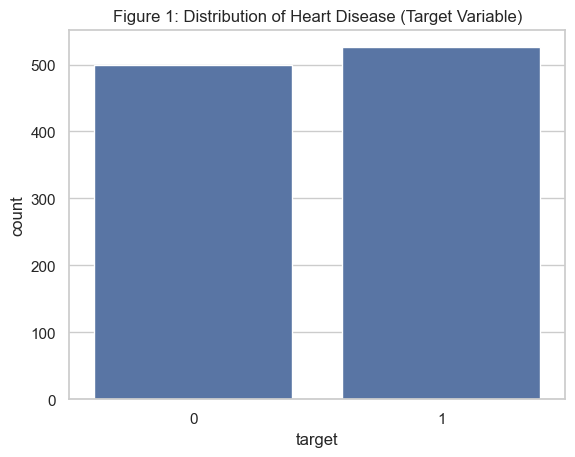

In [6]:
sns.countplot(x="target", data=df_encoded)
plt.title("Figure 1: Distribution of Heart Disease (Target Variable)")
plt.show()

The target value looks to have a fair distribution so I don't need to worry about class imbalances or misleading accuracy metrics.

Encode the categorical values so that I can see which values have high correlation with our target variable

Top 10 most correlated features with the target variable:

chest_pain_type_Typical angina        0.519621
thalassemia_Reversable Defect         0.479709
vessels_colored_by_flourosopy_Zero    0.465981
oldpeak                               0.438441
exercise_induced_angina_Yes           0.438029
Max_heart_rate                        0.422895
slope_Flat                            0.349417
chest_pain_type_Non-anginal pain      0.319504
sex_Male                              0.279501
vessels_colored_by_flourosopy_Two     0.276566
Name: target, dtype: float64


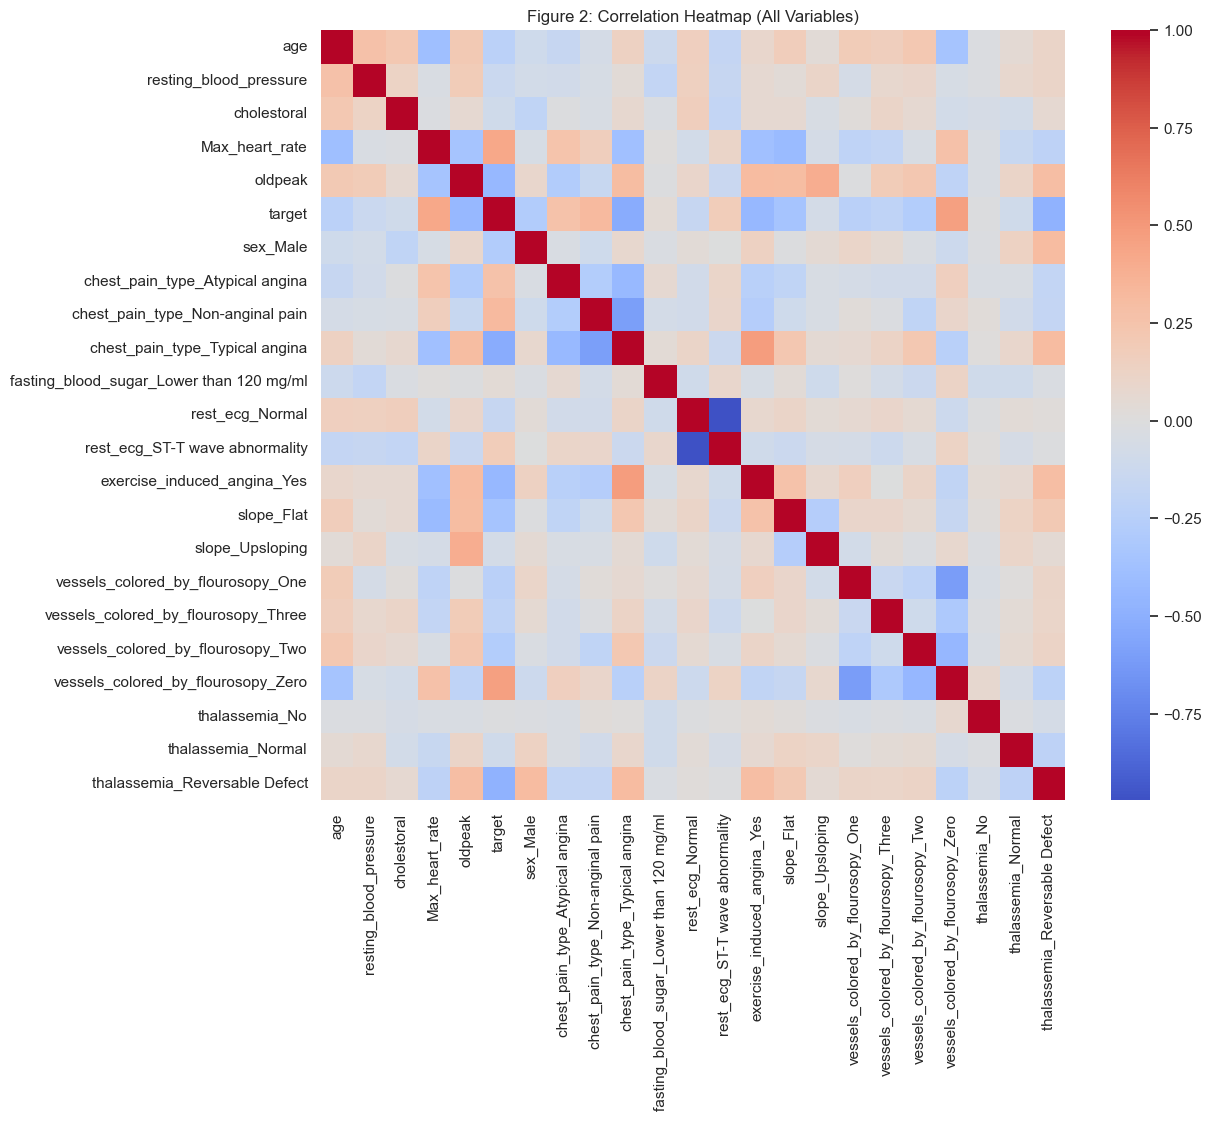

In [7]:
plt.figure(figsize=(12,10))
corr = df_encoded.corr()

top_features = corr["target"].abs().sort_values(ascending=False).head(11).drop("target") 
print("Top 10 most correlated features with the target variable:\n")
print(top_features)

sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Figure 2: Correlation Heatmap (All Variables)")
plt.show()

Results from exploration (including LOTs of research into heart disease testing and what all the symptoms and terminology means): 

The correlation analysis found several features in the dataset that have strong correlation with heart disease. 

- The variable `chest_pain_type_Typical` angina showed the highest positive correlation (0.52) with the target variable, which suggests that individuals who experience typical angina are more likely to have underlying heart disease. Angina is a common symptom of restricted blood flow to the heart.

- `thalassemia_Reversable Defect` (0.48), suggests that patients with reversible thalassemia defects (abnormal results from cardiac imaging tests) are more likely to have heart disease. The next closest correlated variable, `vessels_colored_by_flourosopy_Zero` (0.47), implies that individuals showing no visible blood vessels during fluoroscopy (which an indicator of possible blockage) also tend to have higher disease likelihood.

- The next two variables are related to exercise and stress testing.  The continuous variable `oldpeak` (0.44) measures ECG abnormalities and suggests higher disease risk. The categorical variable `exercise_induced_angina_Yes` (0.44) supports this pattern—those who develop angina during exercise are more likely to have heart disease.

- The last strongly correlated variable is `Max_heart_rate` (0.42) showed a positive correlation, which might suggest that a higher maximum heart rate is associated with heart disease.  In my research, I noticed that this relationship can often be negative, so (pending time) I will dig into this further to see if this is an issue with encoding or the dataset, or is a true representation of correlation.

There are other features that have moderate correlation will be kept in the model, though their correlation may be too weak to be meaningful:
 - `slope_Flat` (0.35), another exercise test showing a flat ECG slope
 - `chest_pain_type_Non-anginal pain` (0.32), is a self-reported value, which tend to be less reliable
 - `sex_Male` (0.28) confirms that males in this dataset have higher disease prevalence, which is consistent with well-known demographic characteristics  - `vessels_colored_by_flourosopy_Two` (0.28) has a weaker or non-linear correlation than the similar highly corrrelated variable noted above.

Overall, these patterns align with well-known cardiovascular risk indicators (especially those related to chest pain characteristics, ECG abnormalities, and imaging results) so the initial exploration confirms that this data is realistic and useful for modeling.  I will keep only the strong features in the features used in the model.

### Feature Selection and Model training {-}

In [8]:
threshold = 0.25  # cutoff to only get 

strong_features = corr["target"][abs(corr["target"]) >= threshold].index.tolist()
strong_features.remove("target")
print(f"Number of strong features: {len(strong_features)}")
print("Selected features:\n", strong_features)

df_strong = df_encoded[strong_features + ["target"]]
print("\nNew dataset shape:", df_strong.shape)

Number of strong features: 11
Selected features:
 ['Max_heart_rate', 'oldpeak', 'sex_Male', 'chest_pain_type_Atypical angina', 'chest_pain_type_Non-anginal pain', 'chest_pain_type_Typical angina', 'exercise_induced_angina_Yes', 'slope_Flat', 'vessels_colored_by_flourosopy_Two', 'vessels_colored_by_flourosopy_Zero', 'thalassemia_Reversable Defect']

New dataset shape: (1025, 12)


In [9]:
# Split features and target
X = df_strong.drop("target", axis=1)
y = df_strong["target"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



A logistic regression is a simple place to start, though I plan on using a boosted algorithm because they tend to work well for tabular data (like medical test results)

In [10]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

### Model Evaluation and Conclusions {-}


Accuracy: 0.873
AUC: 0.936

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.84      0.87       100
           1       0.86      0.90      0.88       105

    accuracy                           0.87       205
   macro avg       0.87      0.87      0.87       205
weighted avg       0.87      0.87      0.87       205



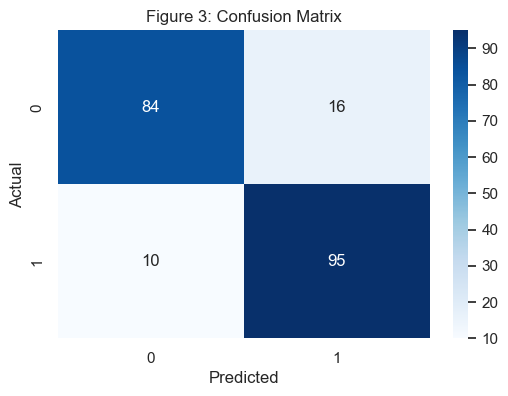

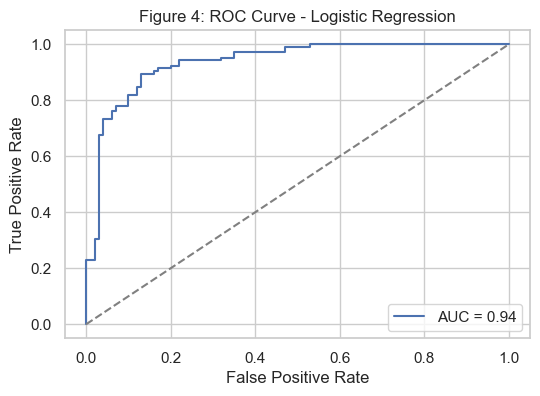

Average CV AUC: 0.932


In [11]:
# Accuracy and report
accuracy = accuracy_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
print(f"\nAccuracy: {accuracy:.3f}")
print(f"AUC: {auc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Figure 3: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("Figure 4: ROC Curve - Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

cv_auc = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring="roc_auc")
print(f"Average CV AUC: {cv_auc.mean():.3f}")


The logistic regression shows an AUC ≈ 0.94, which means this model can correctly rank a randomly chosen heart disease patient higher than a randomly chosen healthy patient 94% of the time, which is _very_ good performance for a medical classification problem.  I mentioned the concern about overfitting above, so cross-validation (or k-fold) may help to make sure we're not overfitting.

I also want to make sure that the features selected are actually important.

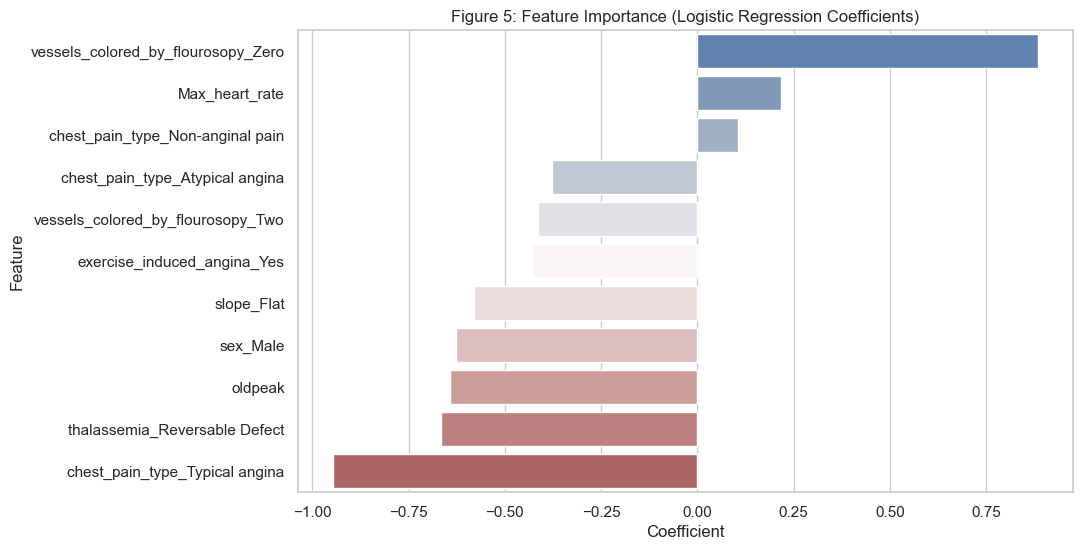


Top 5 positive predictors:
                               Feature  Coefficient
9  vessels_colored_by_flourosopy_Zero     0.883677
0                      Max_heart_rate     0.217071
4    chest_pain_type_Non-anginal pain     0.105380
3     chest_pain_type_Atypical angina    -0.376664
8   vessels_colored_by_flourosopy_Two    -0.413367

Top 5 negative predictors:
                            Feature  Coefficient
7                       slope_Flat    -0.580790
2                         sex_Male    -0.628162
1                          oldpeak    -0.641473
10   thalassemia_Reversable Defect    -0.665211
5   chest_pain_type_Typical angina    -0.946265


In [12]:
importance = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x="Coefficient", y="Feature", data=importance, palette="vlag", hue="Feature")
plt.title("Figure 5: Feature Importance (Logistic Regression Coefficients)")
plt.show()

print("\nTop 5 positive predictors:\n", importance.head())
print("\nTop 5 negative predictors:\n", importance.tail())

The logistic regression model achieved very good accuracy (concerns about overfitting, so that will require more confirmation) and AUC, suggesting this model has reliable predictive power for identifying heart disease. Key predictors included chest pain type, maximum heart rate, and
exercise-induced angina.

Future improvements could include:
 - Testing a Gradient Boosting model
 - Hyperparameter tuning
 - Running a similar analysis and modeling process on a data that that incorporates demographic or lifestyle data (to get better generalization

In [13]:
#### Comparing a Gradient Boosting algorithm

 I'll begin with simple hyperparameters that can balance bias and variance well.
 
- A max depth of 3 will keep the tree complexity shallow enough to reduce overfitting but can still capture interactions between features.
- Lowering the learning rate to 0.05 will help reduce the risk of overfitting.  A smaller learning rate can help the model learn gradually instead of overfitting based on subtle patterns.
- I needed to increase the number of boosting rounds to 200 because too small of a number with that slower learning rate can often underfit a model.  This should still be small enough not to blow up the model's complexity, but deal with the slower learning rate.

=== Gradient Boosting Classifier Report ===
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       100
           1       0.94      0.94      0.94       105

    accuracy                           0.94       205
   macro avg       0.94      0.94      0.94       205
weighted avg       0.94      0.94      0.94       205

AUC: 0.9834285714285714
Confusion Matrix:
[[94  6]
 [ 6 99]]


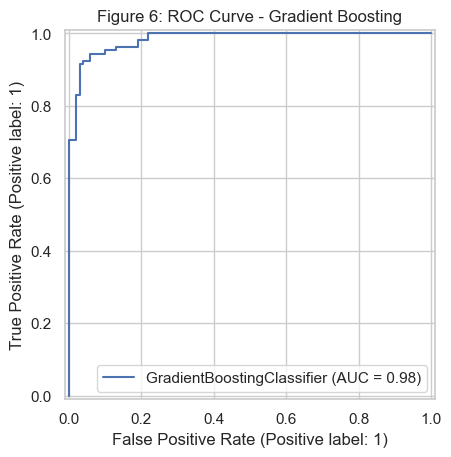

In [14]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import RocCurveDisplay

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gb.fit(X_train, y_train)
gb_pred = gb.predict(X_test)
gb_pred_prob = gb.predict_proba(X_test)[:, 1]

print("=== Gradient Boosting Classifier Report ===")
print(classification_report(y_test, gb_pred))
print("AUC:", roc_auc_score(y_test, gb_pred_prob))

# Confusion Matrix
cm = confusion_matrix(y_test, gb_pred)
print("Confusion Matrix:")
print(cm)

# ROC Curve
RocCurveDisplay.from_estimator(gb, X_test, y_test)
plt.title("Figure 6: ROC Curve - Gradient Boosting")
plt.show()

In [15]:
log_reg_pred = log_reg.predict(X_test)
log_reg_pred_prob = log_reg.predict_proba(X_test)[:, 1]
print("Logistic Regression AUC:", roc_auc_score(y_test, log_reg_pred_prob))
print("Gradient Boosting AUC:", roc_auc_score(y_test, gb_pred_prob))

Logistic Regression AUC: 0.8227619047619047
Gradient Boosting AUC: 0.9834285714285714


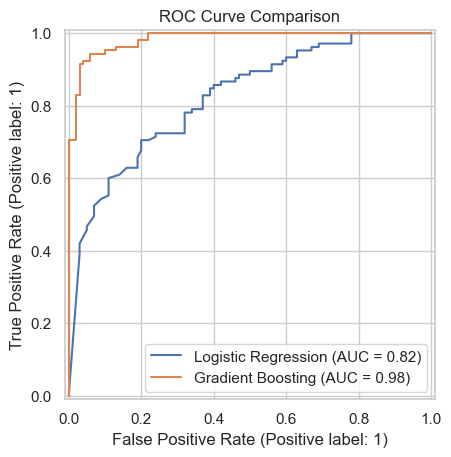

In [16]:
fig, ax = plt.subplots()

RocCurveDisplay.from_predictions(
    y_test, log_reg_pred_prob, name="Logistic Regression", ax=ax
)

RocCurveDisplay.from_predictions(
    y_test, gb_pred_prob, name="Gradient Boosting", ax=ax
)

plt.title("ROC Curve Comparison")
plt.show()

I chose to explore Gradient Boosting because it often outperforms a logistic regression.  This is because it is able to handle complex
relationships between variables, and captures non-linear interactions automatically.  The means it can often achieve a higher AUC and better recall in imbalanced problems like predicting heart disease.  

The regression model is a good baseline, but gradient boosting demonstrates what a modern model can do on the same kind of data.